# EDA of Claim Dataaset
# 02_EDA_Claim

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 24/09/2025 | Adrienne | Created   | Created to do EDA for Claim Dataset | 
| 27/09/2025 | Adrienne | Updated | Added code from Martin |
| 13/10/2025 | Martin | Updated | Code cleanup |

# Content

* [Load Data](#load-data)
* [Data Exploration](#data-exploration)
  * [Observations on Code List](#observations-on-code-lists)
  * [Observations on Percentage of Values](#observations-on-percentage-of-values)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
#import json_lines
import seaborn as sns
import statistics

# Load Data

In [3]:
# readin clean datafiles
path = "../data/clean/"
claim_df =  pd.read_pickle(path + 'claim.pkl')

In [4]:
# readin secondary datasets
mapper_path = "../data/mappers/"
drg_df = pd.read_pickle(mapper_path + 'drg.pkl') 
hcpcs_df = pd.read_pickle(mapper_path + 'hcpcs.pkl')
icd10_df = pd.read_pickle(mapper_path + 'icd10.pkl')

In [5]:
# Additional preprocessing
icd10_df = icd10_df.rename({
  "SHORT DESCRIPTION (VALID ICD-10 FY2025)": "SHORT DESCRIPTION"
}, axis=1)

# Data Exploration

## Observations on Code Lists

<u>Findings</u>

- ICD-10 codes are in almost all claims
- ~56% of ICD-10 lists are length 1 or 2 in length
- HCPCS list that we currently have is just the HCPCS level II codes.  Need to get level I and combine

#### ICD-10

In [6]:
print(f"Number of non-NaN ICD10 entries: {claim_df.shape[0] - claim_df['diagnosis_ls'].apply(lambda x: len(x) == 0).sum()} out of {len(claim_df)}")

Number of non-NaN ICD10 entries: 178570 out of 178761


In [7]:
non_na_icd10 = claim_df[~claim_df['diagnosis_ls'].apply(lambda x: len(x) == 0)]
non_na_icd10['ls_len'] = non_na_icd10['diagnosis_ls'].str.len()
non_na_icd10['first_icd10'] = non_na_icd10['diagnosis_ls'].str[0]

/tmp/ipykernel_594231/1123325870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_icd10['ls_len'] = non_na_icd10['diagnosis_ls'].str.len()
/tmp/ipykernel_594231/1123325870.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_icd10['first_icd10'] = non_na_icd10['diagnosis_ls'].str[0]


In [8]:
na_icd10 = claim_df[claim_df['diagnosis_ls'].apply(lambda x: len(x) == 0)]

Text(0.5, 0, 'Count')

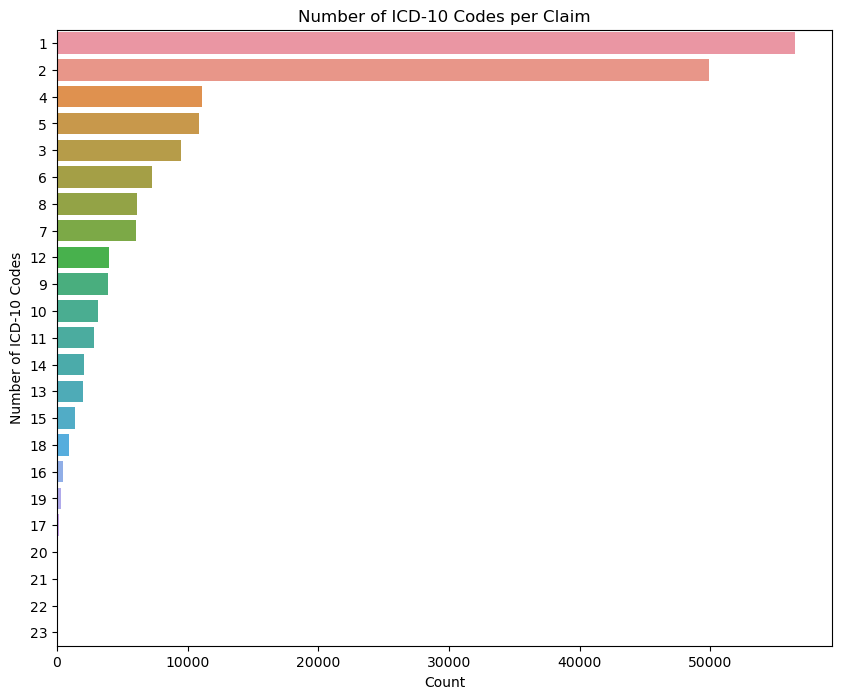

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(y='ls_len', data=non_na_icd10, order=non_na_icd10['ls_len'].value_counts().index)
ax.set_title("Number of ICD-10 Codes per Claim")
ax.set_ylabel("Number of ICD-10 Codes")
ax.set_xlabel("Count")

In [10]:
len_one_and_two = len(non_na_icd10[non_na_icd10['ls_len']== 1]) + len(non_na_icd10[non_na_icd10['ls_len']== 2])
print(f"Number of claims with 1 and 2 ICD-10 Codes: {len_one_and_two}")

Number of claims with 1 and 2 ICD-10 Codes: 106400


In [11]:
def count_icd10(length):
  return len(non_na_icd10[non_na_icd10['ls_len'] == length])

In [12]:
lengths = [11, 19, 21, 22, 23]
for i in lengths:
  print(f"Number of claims with {i} ICD-10 Codes: {count_icd10(i)}")

Number of claims with 11 ICD-10 Codes: 2866
Number of claims with 19 ICD-10 Codes: 303
Number of claims with 21 ICD-10 Codes: 29
Number of claims with 22 ICD-10 Codes: 3
Number of claims with 23 ICD-10 Codes: 1


### HCPCS

In [13]:
print(f"Number of non-NaN HCPCS entries: {claim_df.shape[0] - claim_df['hcpcs_ls'].apply(lambda x: len(x) == 0).sum()} out of {len(claim_df)}")

Number of non-NaN HCPCS entries: 93842 out of 178761


In [14]:
non_na_hcpcs = claim_df[~claim_df['hcpcs_ls'].apply(lambda x: len(x) == 0)]
non_na_hcpcs['ls_len'] = non_na_hcpcs['hcpcs_ls'].str.len()
non_na_hcpcs['first_hcpcs'] = non_na_hcpcs['hcpcs_ls'].str[0]

/tmp/ipykernel_594231/3941366260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['ls_len'] = non_na_hcpcs['hcpcs_ls'].str.len()
/tmp/ipykernel_594231/3941366260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['first_hcpcs'] = non_na_hcpcs['hcpcs_ls'].str[0]


Text(0.5, 0, 'Count')

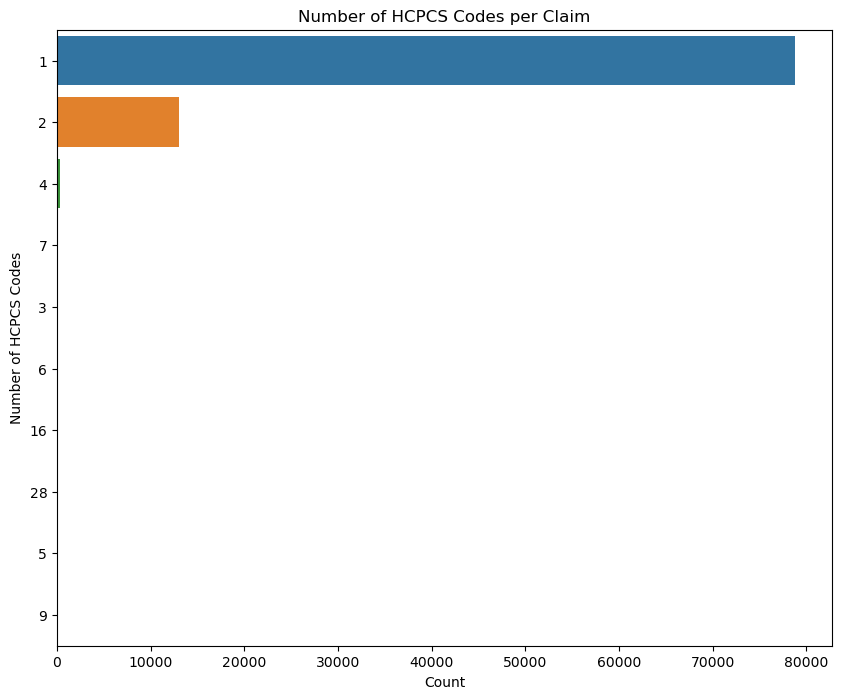

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
ls= non_na_hcpcs['ls_len'].value_counts().head(10)
sns.countplot(y='ls_len', data=non_na_hcpcs, order=ls.index)
ax.set_title("Number of HCPCS Codes per Claim")
ax.set_ylabel("Number of HCPCS Codes")
ax.set_xlabel("Count")

In [16]:
print(f"Min length: {non_na_hcpcs['ls_len'].min()}")
print(f"Max length: {non_na_hcpcs['ls_len'].max()}")
print(f"Median length: { statistics.median(non_na_hcpcs['ls_len'])}")

Min length: 1
Max length: 350
Median length: 1.0


In [17]:
unique_values = set(value for sublist in claim_df['hcpcs_ls'] for value in sublist)
print(unique_values)
print(f"Number of unqiue HCPCS in all claims: {len(unique_values)}")

{'G0299', 'S9129', 'G0156', 'C8905', 'G9573', 'G0155', 'G0152', 'G8159', 'G0154', 'G9572', 'G0107', 'G0157', 'G0444', 'G9857', 'G0102', 'G0458', '99221', 'S9473', 'S0605', 'G9833', '00777310502', 'T1021', 'G8111', 'G0129', 'G0464', 'H2000', 'G0424', 'G9708', 'G0153', 'T1502', 'S8075', 'C8908', 'S9131', 'G0402', 'G0158', 'S9126', '99241', 'C8928', 'Q5001', 'G0151', 'S9122', 'G9858', 'G9829', 'I3C', 'G0300', 'G8946'}
Number of unqiue HCPCS in all claims: 46


In [18]:
unique_ls = list(unique_values)
un_df = pd.DataFrame({'list_col' : unique_ls})
df = pd.merge(un_df, hcpcs_df, how = 'left',left_on='list_col', right_on= 'Code')
df.head(40)

,list_col,Code,Description
0,G0299,G0299,Direct skilled nursing services of a registere...
1,S9129,S9129,"Occupational therapy, in the home, per diem"
2,G0156,G0156,Services of home health/hospice aide in home h...
3,C8905,C8905,Magnetic resonance imaging without contrast fo...
4,G9573,G9573,Adult patients 18 years of age or older with m...
5,G0155,G0155,Services of clinical social worker in home hea...
6,G0152,G0152,Services performed by a qualified occupational...
7,G8159,NaN,NaN
8,G0154,G0154,Direct skilled nursing services of a licensed ...
9,G9572,G9572,Index date phq-score greater than 9 documented...


## Observations on Percentage of Values

<u>Findings</u>

- ICD-10 list is not complete.  About a third of codes aren't merging with a description
- 92.5% of all claims have no HCPCS in procedure list.  The ones that are in there do not merge with a description
- DRG code list is complete enough.  There are some that did not merge with a description
- 77% of claims are institutional which are inpatient and outpatient services provided by a healthcare facility like a hospital
- There are HCPCS codes that are 11 in length that make up 12.175262% of the data which are actually national drug codes (NDC).  There are codes that are 3 in length that make up 0.155099% of the data all with value I3C.

### ICD-10

In [19]:
# Percentage breakdown
vals = non_na_icd10['diagnosis_ls'].value_counts(normalize=True) * 100
pd.DataFrame({
  'ICD10_breakdown': vals
}).head(20)

,ICD10_breakdown
diagnosis_ls,
[E669],5.254522
[D649],3.100185
[E785],3.003864
[J329],2.281458
[O039],1.624573
[E781],1.458252
[R739],1.448172
[I10],1.374811
[P292],1.240970


In [20]:
# Percentage breakdown
vals = non_na_icd10['first_icd10'].value_counts(normalize=True) * 100
icd10_vals = vals.to_frame().reset_index()
df = pd.merge(icd10_vals, icd10_df[['CODE', 'SHORT DESCRIPTION']], how = 'left',left_on='first_icd10', right_on= 'CODE') 
df[['first_icd10', 'SHORT DESCRIPTION', 'proportion']].head(20)

,first_icd10,SHORT DESCRIPTION,proportion
0,E669,"Obesity, unspecified",15.547964
1,D649,"Anemia, unspecified",8.898471
2,J329,"Chronic sinusitis, unspecified",7.197738
3,E785,"Hyperlipidemia, unspecified",6.821975
4,E781,Pure hyperglyceridemia,5.686845
5,O039,Complete or unsp spontaneous abortion without ...,4.783558
6,R739,"Hyperglycemia, unspecified",4.612757
7,K37,Unspecified appendicitis,3.487708
8,I10,Essential (primary) hypertension,3.369547
9,P292,Neonatal hypertension,3.267626


In [21]:
df[['first_icd10', 'SHORT DESCRIPTION', 'proportion']].tail(50)

,first_icd10,SHORT DESCRIPTION,proportion
133,J45909,"Unspecified asthma, uncomplicated",0.01624
134,S303XX,NaN,0.01624
135,J208,Acute bronchitis due to other specified organisms,0.01624
136,R05,Cough,0.01568
137,J069,"Acute upper respiratory infection, unspecified",0.01512
138,S81009,NaN,0.01456
139,S72009,NaN,0.01400
140,K625,Hemorrhage of anus and rectum,0.01344
141,Z3480,NaN,0.01176
142,J3089,Other allergic rhinitis,0.01176


In [22]:
print(f"Number of ICD-10 codes that does not merge with a description: {len(df[ df['SHORT DESCRIPTION'].isnull() ] )} out of {len(df)}")

Number of ICD-10 codes that does not merge with a description: 40 out of 183


### HCPCS

In [23]:
# Percentage breakdown
vals = non_na_hcpcs['hcpcs_ls'].value_counts(normalize=True) * 100
pd.DataFrame({
  'hcpcs_breakdown': vals
}).head(10)

,hcpcs_breakdown
hcpcs_ls,
[99241],51.180708
[G0444],19.458238
"[99241, 00777310502]",8.125360
[99221],6.286098
"[G0444, 00777310502]",2.379532
"[99221, 00777310502]",0.964387
"[G0444, G9573]",0.667079
"[G0444, G9572]",0.648963
[S8075],0.578632


In [24]:
# Percentage breakdown
vals = non_na_hcpcs['first_hcpcs'].value_counts(normalize=True) * 100
hcpcs_vals = vals.to_frame().reset_index()
df = pd.merge(hcpcs_vals, hcpcs_df, how = 'left',left_on='first_hcpcs', right_on= 'Code') 
df[['first_hcpcs', 'Description', 'proportion']].head(20)

,first_hcpcs,Description,proportion
0,99241,NaN,59.306068
1,G0444,"Annual depression screening, 5 to 15 minutes",23.320049
2,99221,NaN,7.250485
3,G0402,Initial preventive physical examination; face-...,1.826474
4,S8075,NaN,0.668144
5,G8111,NaN,0.586092
6,G0151,Services performed by a qualified physical the...,0.573304
7,S9131,"Physical therapy; in the home, per diem",0.561582
8,G0157,Services performed by a qualified physical the...,0.556254
9,G0299,Direct skilled nursing services of a registere...,0.529614


In [25]:
print(f"Number of HCPCS codes that does not merge with a description: {len(df[ df['Description'].isnull() ] )} out of {len(df)}")


Number of HCPCS codes that does not merge with a description: 7 out of 41


In [26]:
non_na_hcpcs['length_counts'] = non_na_hcpcs['hcpcs_ls'].apply(lambda x: max([len(code) for code in x]))
non_na_hcpcs.head()

/tmp/ipykernel_594231/3782310557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['length_counts'] = non_na_hcpcs['hcpcs_ls'].apply(lambda x: max([len(code) for code in x]))


,billablePeriod_end,billablePeriod_start,contained_0_birthDate,contained_0_gender,contained_0_id,contained_0_identifier_0_type_coding_0_code,contained_0_identifier_0_type_coding_0_display,contained_0_identifier_0_value,contained_0_name_0_family,contained_0_name_0_given,...,location_of_bill,gender,diagnosis_ls,admitting_diagnosis,principal_diagnosis,hcpcs_ls,procedure_ls,ls_len,first_hcpcs,length_counts
0,2012-09-16,2012-09-16,1944-05-25,female,patient,MC,Patient's Medicare Number,1S00E00JK17,Wiza601,"[""Patrina117""]",...,2,female,"[R52, R739, E1149, E119, E781, E8881, T50904, ...",T50904,T50904,[99221],[],1,99221,5
1,2013-06-11,2013-06-11,1944-05-25,female,patient,MC,Patient's Medicare Number,1S00E00JK17,Wiza601,"[""Patrina117""]",...,2,female,"[R52, R739, E1142, E119, E781, E8881, T50904, ...",T50904,T50904,[99221],[],1,99221,5
2,2014-04-02,2014-04-01,1944-05-25,female,patient,MC,Patient's Medicare Number,1S00E00JK17,Wiza601,"[""Patrina117""]",...,2,female,"[R52, R739, E1149, E119, E781, E8881, T50904, ...",nan,R52,[99221],[],1,99221,5
3,2014-11-18,2014-11-17,1944-05-25,female,patient,MC,Patient's Medicare Number,1S00E00JK17,Wiza601,"[""Patrina117""]",...,2,female,"[R52, R739, E1149, E119, E781, E8881, T50904, ...",nan,R52,[99221],[],1,99221,5
4,2016-04-04,2016-04-04,1944-05-25,female,patient,MC,Patient's Medicare Number,1S00E00JK17,Wiza601,"[""Patrina117""]",...,2,female,"[R52, R739, E1143, E119, E781, E8881, T50904, ...",T50904,T50904,[99221],[],1,99221,5


In [27]:
non_na_hcpcs['length_counts'] = non_na_hcpcs['hcpcs_ls'].apply(lambda x: max([len(code) for code in x]))
vals = non_na_hcpcs['length_counts'].value_counts(normalize=True) * 100
pd.DataFrame({
  'length_breakdown': vals
}).head(22)

/tmp/ipykernel_594231/3623794473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['length_counts'] = non_na_hcpcs['hcpcs_ls'].apply(lambda x: max([len(code) for code in x]))


,length_breakdown
length_counts,
5,87.774131
11,12.011679
3,0.214190


In [28]:
non_na_hcpcs[non_na_hcpcs['length_counts'] == 3]

,billablePeriod_end,billablePeriod_start,contained_0_birthDate,contained_0_gender,contained_0_id,contained_0_identifier_0_type_coding_0_code,contained_0_identifier_0_type_coding_0_display,contained_0_identifier_0_value,contained_0_name_0_family,contained_0_name_0_given,...,location_of_bill,gender,diagnosis_ls,admitting_diagnosis,principal_diagnosis,hcpcs_ls,procedure_ls,ls_len,first_hcpcs,length_counts
1242,2021-09-29,2021-09-29,1952-06-30,female,patient,MC,Patient's Medicare Number,1S00E00GA15,Lesch175,"[""Mayme605""]",...,2,female,"[E785, I2510, D649, I50813, O039, J329, I50810]",nan,I50810,[I3C],[B24DZZZ],1,I3C,3
1998,2019-06-11,2019-06-11,1950-08-08,male,patient,MC,Patient's Medicare Number,1S00E00JK55,Soliz209,"[""Benjam\u00edn45""]",...,2,male,"[I639, D4959, D075, I2510, F329, P292, E669, I...",nan,I639,[I3C],[B245ZZZ],1,I3C,3
4702,2021-01-09,2021-01-09,1946-05-26,female,patient,MC,Patient's Medicare Number,1S00E00HC20,Greenfelder433,"[""Sibyl335""]",...,2,female,"[I50810, K37, Z9049, I501]",nan,I501,[I3C],[B246ZZ3],1,I3C,3
4709,2022-01-05,2022-01-05,1946-05-26,female,patient,MC,Patient's Medicare Number,1S00E00HC20,Greenfelder433,"[""Sibyl335""]",...,2,female,"[I509, K37, Z9049, I50810]",nan,I50810,[I3C],[B244ZZZ],1,I3C,3
4946,2014-04-22,2014-04-22,1956-05-08,female,patient,MC,Patient's Medicare Number,1S00E00KJ09,Spinka232,"[""Sau887""]",...,2,female,"[I639, J329, O039, I10, E669]",nan,I639,[I3C],[B24DZZ3],1,I3C,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174319,2016-07-27,2016-07-27,1942-09-30,male,patient,MC,Patient's Medicare Number,1S00E00JA49,Monahan736,"[""Rickie717""]",...,2,male,"[K011, G43719, R52, I4891, T50904, G309, E669,...",nan,K011,[I3C],[B244ZZZ],1,I3C,3
174659,2016-12-26,2016-12-26,1954-08-23,male,patient,MC,Patient's Medicare Number,1S00E00JE88,Barrows492,"[""Jere230""]",...,2,male,"[I4891, E669, I639]",nan,I4891,[I3C],[B246ZZ4],1,I3C,3
174898,2015-04-06,2015-04-06,1945-06-25,female,patient,MC,Patient's Medicare Number,1S00E00GE31,Jiménez568,"[""Alicia629""]",...,2,female,"[J329, I469, Z8674, E669, O039]",nan,J329,[I3C],[B24DZZ4],1,I3C,3
177741,2014-09-10,2014-09-10,1945-03-21,female,patient,MC,Patient's Medicare Number,1S00E00JT90,Anaya940,"[""Juana825""]",...,2,female,"[K37, O039, I639, J329, D649, Z9049]",nan,K37,[I3C],[B245ZZ4],1,I3C,3


In [29]:
non_na_hcpcs['first_icd10'] = non_na_hcpcs['diagnosis_ls'].str[0]
df = non_na_hcpcs[['first_icd10', 'first_hcpcs']].drop_duplicates()
df = pd.merge(df, hcpcs_df, how = 'left',left_on='first_hcpcs', right_on= 'Code') 
df = pd.merge(df, icd10_df[['CODE', 'SHORT DESCRIPTION']], how = 'left',left_on='first_icd10', right_on= 'CODE') 
print(f"Number of unique pairs: {len(df)}")
df.head()

Number of unique pairs: 1632


/tmp/ipykernel_594231/4206087544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['first_icd10'] = non_na_hcpcs['diagnosis_ls'].str[0]


,first_icd10,first_hcpcs,Code,Description,CODE,SHORT DESCRIPTION
0,R52,99221,NaN,NaN,R52,"Pain, unspecified"
1,R52,G0444,G0444,"Annual depression screening, 5 to 15 minutes",R52,"Pain, unspecified"
2,R52,99241,NaN,NaN,R52,"Pain, unspecified"
3,R52,G0464,G0464,Colorectal cancer screening; stool-based dna a...,R52,"Pain, unspecified"
4,E669,99221,NaN,NaN,E669,"Obesity, unspecified"


### Procedure

In [30]:
# Percentage breakdown
vals = claim_df['procedure_ls'].value_counts(normalize=True) * 100
pd.DataFrame({
  'procedure_breakdown': vals
}).head(10)

,procedure_breakdown
procedure_ls,
[],92.514027
[BW03ZZZ],1.111540
[0U2DXHZ],0.828480
[BH00ZZZ],0.405010
[BH01ZZZ],0.396060
[BH02ZZZ],0.378159
[09JY4ZZ],0.301520
[B244ZZZ],0.196352
[B24DZZZ],0.178451


In [31]:
claim_df['proc_ls_len'] = claim_df['procedure_ls'].str.len()
print(f"min length: {claim_df['proc_ls_len'].min()}")
print(f"max length: {claim_df['proc_ls_len'].max()}")

min length: 0
max length: 25


### DRG

In [32]:
# Percentage breakdown
claim_df['drg_pad'] = claim_df['drg_code'].apply( lambda x : '{0:0>3}'.format(x)) 
vals = claim_df['drg_pad'].value_counts(normalize=True) * 100
drg_vals = vals.to_frame().reset_index()
df = pd.merge(drg_vals, drg_df, how = 'left',left_on='drg_pad', right_on= 'DRG') 
df[['drg_pad', 'DRG_description', 'proportion']].head(20)

,drg_pad,DRG_description,proportion
0,nan,NaN,95.210924
1,642,Inborn and other disorders of metabolism,0.301520
2,003,ECMO o r tracheostomy with MV >96 hours or PDX...,0.298723
3,001,Heart transplant or implant of heart assist sy...,0.259564
4,598,Malignant breast disorders with CC,0.228238
5,599,Malignant breast disorders without CC/MCC,0.226559
6,597,Malignant breast disorders with MCC,0.217609
7,582,Mastectomy for malignancy with CC/MCC,0.205861
8,583,Mastectomy for malignancy without CC/MCC,0.204743
9,641,"Miscellaneous disorders of nutrition, metaboli...",0.181807


In [33]:
print(f"Number of DRG codes that does not merge with a description: {len(df[ df['DRG_description'].isnull() ] )} out of {len(df)}")


Number of DRG codes that does not merge with a description: 3 out of 176


In [34]:
df[ df['DRG_description'].isnull() ] 

,drg_pad,proportion,DRG,MDC,DRG_description,MDC_description
0,nan,95.210924,NaN,NaN,NaN,NaN
43,019,0.021257,NaN,NaN,NaN,NaN
167,522,0.000559,NaN,NaN,NaN,NaN


### Type of Bill

In [35]:
# Percentage breakdown
vals = claim_df['type_of_bill'].value_counts(normalize=True) * 100
pd.DataFrame({
  'bill_type_breakdown': vals
}).head(10)

,bill_type_breakdown
type_of_bill,
1,95.570552
B,4.429448


### Claim Type

In [36]:
# Percentage breakdown
vals = claim_df['claim_type'].value_counts(normalize=True) * 100
pd.DataFrame({
  'claim_type_breakdown': vals
}).head(10)

,claim_type_breakdown
claim_type,
institutional,77.177349
professional,22.822651


### Location of Bill

In [37]:
# Percentage breakdown
vals = claim_df['location_of_bill'].value_counts(normalize=True) * 100
pd.DataFrame({
  'location_of_bill_breakdown': vals
}).head(10)

,location_of_bill_breakdown
location_of_bill,
2,91.014982
4,6.957663
3,1.319194
9,0.708161


In [38]:
na_hcpcs = claim_df[claim_df['hcpcs_ls'].apply(lambda x: len(x) == 0)]
vals = na_hcpcs['location_of_bill'].value_counts(normalize=True) * 100
pd.DataFrame({
  'location_of_bill_breakdown': vals
}).head(10)

,location_of_bill_breakdown
location_of_bill,
2,90.577728
4,7.280706
3,1.399898
9,0.741668


Billable Period Start

In [39]:
# look at year of billable period
non_na_hcpcs['year'] = non_na_hcpcs['billablePeriod_start'].apply(lambda x: x[:4])
vals = non_na_hcpcs['year'].value_counts(normalize=True) * 100
pd.DataFrame({
  'year_breakdown': vals
}).head(30)

/tmp/ipykernel_594231/1468730865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['year'] = non_na_hcpcs['billablePeriod_start'].apply(lambda x: x[:4])


,year_breakdown
year,
2021,15.048699
2014,13.918075
2020,9.890028
2019,9.424352
2018,8.754076
2017,8.561199
2016,8.309712
2015,7.950598
2013,7.343194


### Look at Patient and Number of Claims

<u>Findings</u>

All Claims:
- Most common patient has 2550 claims
- Least common has one claim
- There are 410 patients with 20 or less claims

Claims with HCPCS codes:
- Most common patient has 1342
- There are 2419 with 50 claims or less
- There are multiple patients per patient medicare number.  This is resolved by dropping unique_claim_IDs that are not 9 in length as it appears the number indicates garbage data

In [40]:
# Percentage breakdown
vals = claim_df['patient_medicare_number'].value_counts(normalize=True) * 100
pd.DataFrame({
  'med_num_breakdown': vals
}).head(22)

,med_num_breakdown
patient_medicare_number,
1S00E00GT33,1.426486
1S00E00KH30,1.198248
1S00E00GU73,1.164684
1S00E00GJ99,1.089723
1S00E00HT76,0.586258
1S00E00GW62,0.476055
1S00E00JN81,0.312708
1S00E00AA46,0.304876
1S00E00AF73,0.298723


In [41]:
print(f"Most common patient: { len(claim_df[ claim_df['patient_medicare_number'] == '1S00E00GT33'])} claims")
print(f"Least common patient: { len(claim_df[ claim_df['patient_medicare_number'] == '1S00E00HG24'])} claims")
vals = claim_df['patient_medicare_number'].value_counts()
val_df = pd.DataFrame({
  'med_num_breakdown': vals
})
print(f"Number of patients with 20 claims or less: {len(val_df[ val_df['med_num_breakdown'] < 20])}")

Most common patient: 2550 claims
Least common patient: 1 claims
Number of patients with 20 claims or less: 410


In [42]:
# subset of data that have hcpcs
print(f"Number of claims with hcpcs: {len(non_na_hcpcs)}")
print(f"Most common patient: { len(non_na_hcpcs[ non_na_hcpcs['patient_medicare_number'] == '1S00E00GT33'])} claims")
print(f"Least common patient: { len(non_na_hcpcs[ non_na_hcpcs['patient_medicare_number'] == '1S00E00HG24'])} claims")
vals = non_na_hcpcs['patient_medicare_number'].value_counts()
val_df = pd.DataFrame({
  'med_num_breakdown': vals
})
print(f"Number of patients with 50 claims or less: {len(val_df[ val_df['med_num_breakdown'] < 50])}")

Number of claims with hcpcs: 93842
Most common patient: 1342 claims
Least common patient: 0 claims
Number of patients with 50 claims or less: 2419


### Patient birthdate

In [43]:
# unique brithdate by patient medicare number
grp_ser = claim_df.groupby('patient_medicare_number')['contained_0_birthDate'].apply(list)
grp_df = pd.DataFrame({
  'num_birthdate': grp_ser
})
grp_df['ls'] = grp_df['num_birthdate'].apply(lambda x: [code for code in x if pd.notnull(code) ])
grp_df['num_bday'] = grp_df['num_birthdate'].apply(len)
#grp_df = pd.DataFrame( {'location_of_bill_ls': grp_ser})
vals = grp_df['num_bday'].value_counts(normalize=True) * 100
pd.DataFrame({
  'num_breakdown': vals
}).head(22)

,num_breakdown
num_bday,
24,2.959610
22,2.332869
20,2.228412
18,2.123955
26,2.054318
27,1.915042
30,1.880223
21,1.740947
28,1.706128


### Unique Claim ID

In [44]:
claim_df['len_claim'] = claim_df['unique_claim_ID'].str.len()
vals = claim_df['len_claim'].value_counts(normalize=True) * 100
print('original unique_claim_ID lengths')
pd.DataFrame({
  'len_claim': vals
}).head(30)

original unique_claim_ID lengths


,len_claim
len_claim,
9,90.046487
19,5.670141
14,4.283373


In [45]:
non_na_hcpcs['len_claim'] = non_na_hcpcs['unique_claim_ID'].str.len()
vals = non_na_hcpcs['len_claim'].value_counts(normalize=True) * 100
print('when rows without hcpcs are dropped unique_claim_IDs are all nine')
pd.DataFrame({
  'len_claim': vals
}).head(30)

when rows without hcpcs are dropped unique_claim_IDs are all nine


/tmp/ipykernel_594231/163330112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['len_claim'] = non_na_hcpcs['unique_claim_ID'].str.len()


,len_claim
len_claim,
9,100.0


In [46]:
non_na_hcpcs['len_claim'] = non_na_hcpcs['unique_claim_ID'].str.len()
df = non_na_hcpcs[ non_na_hcpcs['len_claim'] == 9]
grp_ser = df.groupby('patient_medicare_number')['contained_0_birthDate'].apply(list)
grp_df = pd.DataFrame({
  'num_birthdate': grp_ser
})
grp_df['num'] = grp_df['num_birthdate'].apply(set)
grp_df['ls'] = grp_df['num'].apply(lambda x: [code for code in x if pd.notnull(code) ])
grp_df['num_bday'] = grp_df['ls'].apply(len)
#grp_df = pd.DataFrame( {'location_of_bill_ls': grp_ser})
vals = grp_df['num_bday'].value_counts(normalize=True) * 100
pd.DataFrame({
  'num_breakdown': vals
}).head(22)

/tmp/ipykernel_594231/1730549236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_hcpcs['len_claim'] = non_na_hcpcs['unique_claim_ID'].str.len()


,num_breakdown
num_bday,
1,99.473499
0,0.526501
